Strategy hypothesis:

1. Today's candle must have a lower high and lower low than yesterday
2. Place an entry at yesterday's high
3. If price hits the entry point then measure the return of the next day

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime

In [20]:
symbols = ["^GSPC"]
systems = ["Reversal", "Down_Reversal", "Momentum", "BuyHold"]
starting_balance = 10000

In [21]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2026, 1, 1)
years = (end - start).days / 365.25

In [22]:
def backtest(symbol):
    
    price = yf.download(symbol, start=start, end=end)
    price = price.drop(['Adj Close', 'Volume'], axis=1)

    #calculate inputs for strategy
    #check if there is a lower high and lower low for a reversal setup
    price['Reversal'] = (price.High < price.High.shift(1)) & (price.Low < price.Low.shift(1))
    price['Down_Reversal'] = (price.High < price.High.shift(1)) & (price.Low < price.Low.shift(1)) & (price.Close < price.Open)
    price['Momentum'] = (price.High > price.High.shift(1)) & (price.Low > price.Low.shift(1))
    price["BuyHold"] = True
    
    #check if there was a signal yesterday and today's high is above yesterday's high
    price['Reversal_Trade'] = (price.Reversal.shift(1) == True) & (price.High > price.High.shift(1)) # lower low system signal
    price['Down_Reversal_Trade'] = (price.Down_Reversal.shift(1) == True) & (price.High > price.High.shift(1)) # lower low system signal
    price['Momentum_Trade'] = (price.Momentum.shift(1) == True) & (price.High > price.High.shift(1)) # momentum system signal
    price["BuyHold_Trade"] = True
    
    for s in systems:
        if s == "BuyHold":
            price[f"{s}_Entry_Price"] = price.Close.shift(1)
        else:
            #calculate the entry price for a reversal trade
            price[f"{s}_Entry_Price"] = np.where(price[f"{s}_Trade"] == True, #if the previous day had a long signal then check where the entry would be
                                        np.where(price.Open > price.High.shift(1), price.Open, price.High.shift(1)), False)
                                        #line above. If the open is above the high, then enter at open, otherwise, enter at yesterday's high
        
        #calculate return for strategy
        price[f"{s}_Ret"] = np.where(price[f"{s}_Trade"] == True, price.Close / price[f"{s}_Entry_Price"], 1)
        if s == "BuyHold":
            price[f"{s}_Ret"].iat[0] = 1#set the first day's return to 1 on buy and hold to avoid NaN value
        price[f"{s}_Bal"] = starting_balance * price[f"{s}_Ret"].cumprod()
    
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price

In [23]:
results = []
for sym in symbols:
    result = backtest(sym)
    results.append(result)

[*********************100%%**********************]  1 of 1 completed


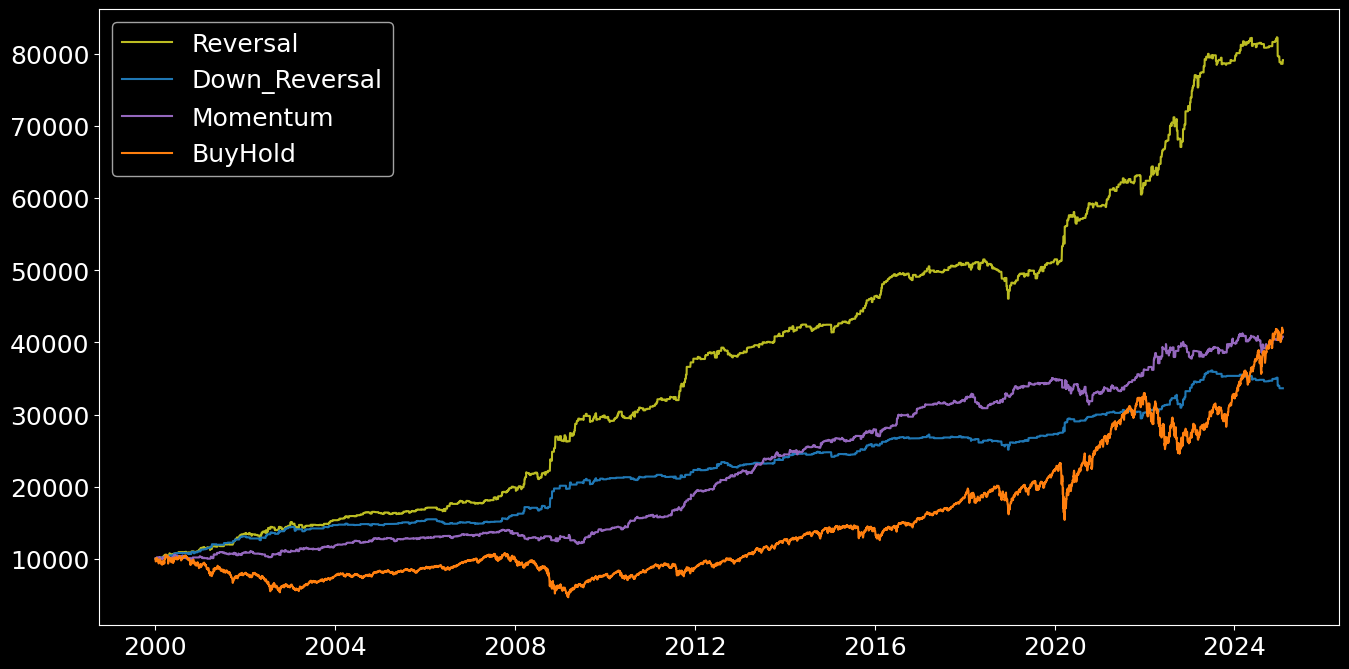

In [24]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams.update({'font.size': 18})

colours = ["tab:olive", "tab:blue", "tab:purple", "tab:orange"]

for c, s in enumerate(systems):
    plt.plot(results[0][f"{s}_Bal"], colours[c])

plt.legend(systems)
plt.show()

In [25]:
#calculate metrics
def get_metrics(system, data):
    metrics = {}
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_dd)
 
    win = (data.Close > data[f"{system}_Entry_Price"]) & (data[f"{system}_Trade"] == True)
    loss = (data.Close < data[f'{system}_Entry_Price']) & (data[f"{system}_Trade"] == True)
    signals = data[system].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round((trades_triggered / len(data)) * 100)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn't scale as TIM increases. Could be wrong)
    gaps = ((data[f"{system}_Trade"] == True) & (data.Open > data.High.shift(1))).sum()
    non_gaps = ((data[f"{system}_Trade"] == True) & (data.Open <= data.High.shift(1))).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    move_size = np.where(data[f"{system}_Trade"] == True, data.Close - data[f"{system}_Entry_Price"], 0)
    avg_up_move = round(move_size[move_size > 0].mean(), 2)
    max_up_move = move_size.max()
    avg_down_move = round(abs(move_size[move_size < 0].mean()), 2)
    max_down_move = move_size.min()
    avg_rr = round(avg_up_move / avg_down_move, 2)

    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    metrics["Time_in_Market"] = round(tim, 2)
    metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    metrics["Return_Over_Drawdown"] = round(rod, 2)
    metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    metrics["Gap"] = round(gaps, 2)
    metrics["No_Gap"] = round(non_gaps, 2)
    metrics["Wins"] = round(wins, 2)
    metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    metrics["Max_Win"] = round(max_up_move, 2)
    metrics["Max_Loss"] = round(max_down_move, 2)
    metrics["Avg_up_move"] = round(avg_up_move, 2)
    metrics["Avg_down_move"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr
    
    return metrics

In [26]:
full_metrics = {}
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)
    full_metrics.update({symbols[count]: sys_metrics_df})

In [27]:
for m in full_metrics:
    print(m)
    print(full_metrics[m])

^GSPC
                      Reversal  Down_Reversal  Momentum   BuyHold
Start_Balance         10000.00       10000.00  10000.00  10000.00
Final_Balance         79171.16       33639.32  40795.09  41499.29
Total_Return            691.71         236.39    307.95    314.99
Annual_Return             8.28           4.78      5.56      5.63
Time_in_Market           15.00           9.00     26.00    100.00
Return_By_Exposure       55.20          53.11     21.38      5.63
Max_Drawdown            -10.57          -7.68    -14.03    -56.78
Return_Over_Drawdown      0.78           0.62      0.40      0.10
RBE_Over_Drawdown         5.22           6.92      1.52      0.10
Signals                2218.00        1639.00   2732.00   6307.00
Trades                  958.00         554.00   1654.00   6307.00
Gap                     167.00          49.00    383.00    685.00
No_Gap                  791.00         505.00   1271.00   5621.00
Wins                    585.00         343.00    942.00   3380.00
Loss